In [2]:
import sqlite3 as sql, pandas as pd # handeling the data
import numpy as np, scipy.stats as stats # performing statistical analyis/mathmatics
import matplotlib.pyplot as plt # visulisations
from sklearn.model_selection import train_test_split # ML
import os # used when debugging to fix an issue with the paths

In [3]:
df = pd.read_csv(r'C:\Users\alloh\OneDrive\Desktop\coding\workspace\CV_projs\SQL & ML\website\instance\exams.csv', encoding = 'latin-1')

In [4]:
df.rename(columns={'race/ethnicity':'ethnicity' ,
                   'parental level of education':'parents_education' ,
                   'test preparation course':'test_prep',
                   'math score':'math',
                   'writing score':'writing',
                   'reading score':'reading'},inplace=True)


In [5]:
with sql.connect(r'C:\Users\alloh\OneDrive\Desktop\coding\workspace\CV_projs\SQL & ML\website\instance\database.db') as conn: # cute bit of file handling
    df.to_sql('name', conn, if_exists = 'replace', index = False)
    # later we may have to use an f-string when the data becomes purely numerical
    try: # we use try here as it's a fun way to practice error handling
        # performing our query to the database
        result1 = pd.read_sql_query(
            f"SELECT AVG(\"math\") AS avg_math, MAX(\"math\") AS max_math, MIN(\"math\") AS min_math \
            FROM name \
            WHERE parents_education = 'associate''s degree' "
            , conn 
            )
        
        result2 = pd.read_sql_query(
            f"SELECT AVG(\"math\") AS avg_math, MAX(\"math\") AS max_math, MIN(\"math\") AS min_math \
            FROM name \
            WHERE parents_education = 'high school' OR parents_education = 'some high school' "
            , conn 
            )
        
        group_meals = {}
        for letter in range(65,70):
            group = f"group {chr(letter)}"
            result3 = pd.read_sql_query(
                f"SELECT COUNT(*) AS cheap_meal \
                FROM name \
                WHERE ethnicity = '{group}' AND lunch = 'free/reduced'"
                ,conn
            )
            group_meals[group] = result3.at[0,"cheap_meal"]
    except Exception as e:
        print(f"an error was found: {e}")

In [6]:
df_html = df[:10].to_html(classes='table table-striped', index=False)

aggragations_highschool = {'mean': round(result1.at[0,f"avg_math"],2),
        'maximum': result1.at[0,f"max_math"],
        'minimum': result1.at[0,f"min_math"],
         'Range': result1.at[0,f"max_math"] - result1.at[0,f"min_math"],
         'standard deviation': round(df[f"math"].std(),2)}

aggragations_associates = {'mean': round(result2.at[0,f"avg_math"],2),
        'maximum': result2.at[0,f"max_math"],
        'minimum': result2.at[0,f"min_math"],
         'Range': result2.at[0,f"max_math"] - result2.at[0,f"min_math"],
         'standard deviation': round(df[f"math"].std(),2)}


C:\Users\alloh\AppData\Local\Temp\ipykernel_24676\1189847554.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


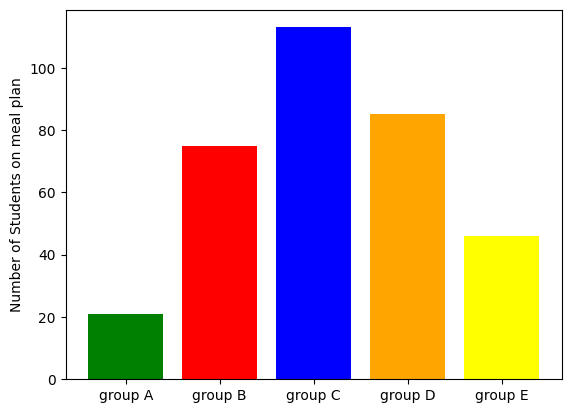

In [7]:
#figure our the problem with this cell
fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Number of Students on meal plan')
ax.bar(list(group_meals.keys()), list(group_meals.values()), color=['green','red','blue','orange','yellow'])
plt.savefig(r'C:\Users\alloh\OneDrive\Desktop\coding\workspace\CV_projs\SQL & ML\website\statics\meals.jpeg')
fig.show()

C:\Users\alloh\AppData\Local\Temp\ipykernel_24676\2519243270.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


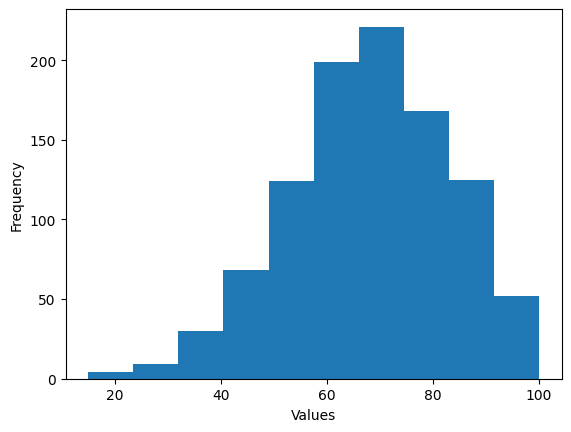

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(df['math'])
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
plt.savefig(r'C:\Users\alloh\OneDrive\Desktop\coding\workspace\CV_projs\SQL & ML\website\statics\maths.jpeg')
fig.show()

C:\Users\alloh\AppData\Local\Temp\ipykernel_24676\1629202973.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


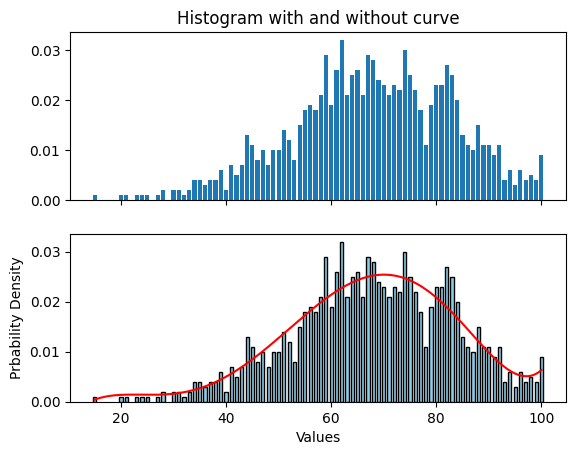

In [9]:
fig, (ax, ay) = plt.subplots(2, sharex=True)
# next we must convert our discrete data into a contineuous probability distribution.
frequincies = df['math'].value_counts(normalize=True)
ax.bar(frequincies.index,frequincies.values)

x = frequincies.index
y = frequincies.values

degree = 6 # we choose 6 as it provides a reasonably accurate approximation
coefficients = np.polyfit(x, y, degree)
polynomial = np.poly1d(coefficients)


x_curve = np.linspace(min(x), max(x), 500)
y_curve = polynomial(x_curve)

ay.bar(x, y, width=0.6, color='skyblue', edgecolor='black', label='Histogram')
ay.plot(x_curve, y_curve, color='red', label=f'Polynomial Degree {degree}')
ay.set_xlabel('Values')
ay.set_ylabel('Prbability Density')
ax.set_title('Histogram with and without curve')
fig.savefig(r'C:\Users\alloh\OneDrive\Desktop\coding\workspace\CV_projs\SQL & ML\website\statics\maths_hist.jpeg')
fig.show()

In [10]:
# performs a T-test on our data
test = stats.ttest_1samp(a = df['math'].values, popmean = aggragations_associates['mean'])
print(test)

# checks if we can reject the null hypothesis
decide = stats.t.ppf(q = 0.025, df = 49)
print(decide)

TtestResult(statistic=6.137850337584206, pvalue=1.2046750452316176e-09, df=999)
-2.0095752344892093


In [11]:

# we may now begin the predictive analysis section of the project which will be used
df['test_prep'] = df['test_prep'].replace('completed', 1)
df['test_prep'] = df['test_prep'].replace('none',0)

df['lunch'] = df['lunch'].replace('standard', 1)
df['lunch'] = df['lunch'].replace('free/reduced',0)


df['gender'] = df['gender'].replace('female',1)
df['gender'] = df['gender'].replace('male',0)

df = df.drop(columns = ['ethnicity','parents_education'])

#spliting the dataset
df

C:\Users\alloh\AppData\Local\Temp\ipykernel_24676\4276327799.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['test_prep'] = df['test_prep'].replace('none',0)
C:\Users\alloh\AppData\Local\Temp\ipykernel_24676\4276327799.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['lunch'] = df['lunch'].replace('free/reduced',0)
C:\Users\alloh\AppData\Local\Temp\ipykernel_24676\4276327799.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explic

,gender,lunch,test_prep,math,reading,writing
0,1,1,1,59,70,78
1,0,1,0,96,93,87
2,1,0,0,57,76,77
3,0,0,0,70,70,63
4,1,1,0,83,85,86
...,...,...,...,...,...,...
995,0,1,0,77,77,71
996,0,1,0,80,66,66
997,1,1,1,67,86,86
998,0,1,0,80,72,62
